<a href="https://colab.research.google.com/github/Sudar-shan/gestureRecognition/blob/main/gesture_recognition_sudarshan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gesture Recognition - Sudarshan
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [5]:
!unzip "/content/gdrive/MyDrive/project_data.zip" > /dev/source

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [6]:
project_folder = '/content/Project_data/'
train_doc = np.random.permutation(open(project_folder +'train.csv').readlines())
val_doc = np.random.permutation(open(project_folder +'val.csv').readlines())
batch_size = 32

In [7]:
# importing model building libraries

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout
from imageio import imread
from skimage.transform import resize

In [8]:
# Utility function to plot accuracy during training

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    print("Max. Training Accuracy", max(history.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(history.history['val_categorical_accuracy']))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
# Creating an abstract model builder class will help to reduce repeating same code again and again
# as we will be building many models and testing them.
# only the define_model function needs to change for each model
class ModelBuilder(metaclass=abc.ABCMeta):
    # only model dfine needs to change per model type and it can use other functions
    # to change needed props and params
    @abc.abstractmethod
    def define_model(self):pass
    # initialising all the necessary paths
    def init_paths(self, project_folder):
        self.train_doc = np.random.permutation(open(project_folder + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + 'val.csv').readlines())
        self.train_path = project_folder + 'train'
        self.val_path = project_folder + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)

    # initialising all image i.e per video seq properties
    def init_img_props(self, image_height=100, image_width=100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30

    # initialising hyperParams
    def init_hyperparams(self, frames_to_sample=30, batch_size=20, num_epochs=20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.num_epochs = num_epochs

    # ***** GENERATOR FUNCTION *****
    def generator(self, source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0, self.total_frames - 1, self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t) // batch_size

            for batch in range(num_batches):
                batch_data, batch_labels = self.one_batch_data(source_path, t, batch, batch_size, img_idx, augment)
                yield batch_data, batch_labels

            remaining_seq = len(t) % batch_size

            if (remaining_seq != 0):
                batch_data, batch_labels = self.one_batch_data(source_path, t, num_batches, batch_size, img_idx,
                                                               augment, remaining_seq)
                yield batch_data, batch_labels
    # Processing Data For One Single Batch
    def one_batch_data(self, source_path, t, batch, batch_size, img_idx, augment, remaining_seq=0):

        seq_len = remaining_seq if remaining_seq else batch_size

        batch_data = np.zeros((seq_len, len(img_idx), self.image_height, self.image_width, self.channels))
        batch_labels = np.zeros((seq_len, self.num_classes))

        if (augment): batch_data_aug = np.zeros(
            (seq_len, len(img_idx), self.image_height, self.image_width, self.channels))

        for folder in range(seq_len):
            imgs = os.listdir(source_path + '/' + t[folder + (batch * batch_size)].split(';')[0])
            for idx, item in enumerate(img_idx):
                # Loading imgs and resizing
                image = imread(source_path + '/' + t[folder + (batch * batch_size)].strip().split(';')[0] + '/' + imgs[
                    item]).astype(np.float32)
                image_resized = resize(image, (self.image_height, self.image_width, 3))

                # normalizing the images
                batch_data[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                batch_data[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                batch_data[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255

                if (augment):
                    shifted = cv2.warpAffine(image,
                                             np.float32([[1, 0, np.random.randint(-30, 30)],
                                                         [0, 1, np.random.randint(-30, 30)]]),
                                             (image.shape[1], image.shape[0]))

                    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0)
                    # processing the images by croping
                    cropped = shifted[x0:x1, y0:y1, :]

                    image_resized = resize(cropped, (self.image_height, self.image_width, 3))

                    batch_data_aug[folder, idx, :, :, 0] = (image_resized[:, :, 0]) / 255
                    batch_data_aug[folder, idx, :, :, 1] = (image_resized[:, :, 1]) / 255
                    batch_data_aug[folder, idx, :, :, 2] = (image_resized[:, :, 2]) / 255

            batch_labels[folder, int(t[folder + (batch * batch_size)].strip().split(';')[2])] = 1

        if (augment):
            batch_data = np.concatenate([batch_data, batch_data_aug])
            batch_labels = np.concatenate([batch_labels, batch_labels])

        return (batch_data, batch_labels)

    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc, augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        #model_name = 'model' + '_' + self.model_name
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        #filepath = '/' + model_name + '/' + model_name + '.h5'
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
                                     save_weights_only=False, mode='auto', save_freq='epoch')
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)

        #earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=10, verbose=1)
        #callbacks_list = [checkpoint, LR, earlystop]
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences % self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences / self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences // self.batch_size) + 1

            if (self.num_val_sequences % self.batch_size) == 0:
                validation_steps = int(self.num_val_sequences / self.batch_size)
            else:
                validation_steps = (self.num_val_sequences // self.batch_size) + 1

            history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs,
                                          verbose=1,
                                          callbacks=callbacks_list, validation_data=val_generator,
                                          validation_steps=validation_steps, class_weight=None, workers=1,
                                          initial_epoch=0)
            return history

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
# ALl this will be handled by the model builder class so commenting this one out
#curr_dt_time = datetime.datetime.now()
#train_path = '/notebooks/storage/Final_data/Collated_training/train'
#val_path = '/notebooks/storage/Final_data/Collated_training/val'
#num_train_sequences = len(train_doc)
#print('# training sequences =', num_train_sequences)
#num_val_sequences = len(val_doc)
#print('# validation sequences =', num_val_sequences)
#num_epochs = # choose the number of epochs
#print ('# epochs =', num_epochs)

## Model Builder
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
class ModelConv3DTest(ModelBuilder):

    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [12]:
conv_3dTest=ModelConv3DTest()
conv_3dTest.init_paths(project_folder)
conv_3dTest.init_img_props(image_height=160,image_width=160)
conv_3dTest.init_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3dTest_model=conv_3dTest.define_model()
conv_3dTest_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16   1312      
                             )                                   
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16   0         
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 30, 160, 160, 16   64        
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 15, 80, 80, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

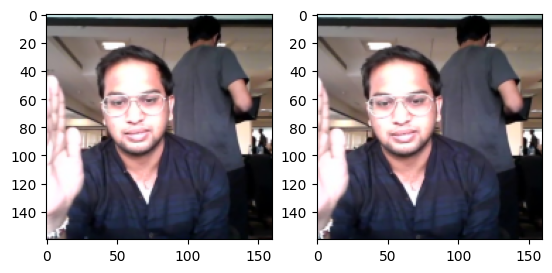

In [13]:
test_generator=ModelConv3DTest()
test_generator.init_paths(project_folder)
test_generator.init_img_props(image_height=160,image_width=160)
test_generator.init_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])
axes[1].imshow(batch_data[3,15,:,:,:])

Deciding image resolution:

1.   We can change frame rate as it is needed with regards to ram usage
2.   Chosen batch size as 3 just to test. will use ~3 to 5 batch size for performance reasons
3.   Different resolution of images is chosen and its perfromance will be tested to choose the right one here.



In [14]:
conv_3dTest=ModelConv3DTest()
conv_3dTest.init_paths(project_folder)
conv_3dTest.init_img_props(image_height=100,image_width=100)
conv_3dTest.init_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)
conv_3dTest_model=conv_3dTest.define_model()
print("Total Params:", conv_3dTest_model.count_params())
conv_3dTest.train_model(conv_3dTest_model)

Total Params: 687813


In [15]:
conv_3dTest=ModelConv3DTest()
conv_3dTest.init_paths(project_folder)
conv_3dTest.init_img_props(image_height=120,image_width=120)
conv_3dTest.init_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)
conv_3dTest_model=conv_3dTest.define_model()
print("Total Params:", conv_3dTest_model.count_params())
conv_3dTest.train_model(conv_3dTest_model)

Total Params: 900805


In [16]:
conv_3dTest=ModelConv3DTest()
conv_3dTest.init_paths(project_folder)
conv_3dTest.init_img_props(image_height=160,image_width=160)
conv_3dTest.init_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)
conv_3dTest_model=conv_3dTest.define_model()
print("Total Params:", conv_3dTest_model.count_params())
conv_3dTest.train_model(conv_3dTest_model)

Total Params: 1736389


Performance of Image size 120,120 seems good but we might need to use 160 if the performance is ok

In [19]:
conv_3dTest = None
conv_3dTest_model = None

# Model-1 :
*   Batch Size -5
*   No of Epochs - 25
*   Image Size - 120,120
*   Frames - 20



In [20]:
class ModelConv3D1(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.15):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [23]:
curr_model_builder=ModelConv3D1()
curr_model_builder.init_paths(project_folder)
curr_model_builder.init_img_props(image_height=120,image_width=120)
curr_model_builder.init_hyperparams(frames_to_sample=20,batch_size=5,num_epochs=25)
curr_model=curr_model_builder.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
curr_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 120, 120, 16   400       
                             )                                   
                                                                 
 activation_20 (Activation)  (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_30 (Ba  (None, 20, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_20 (MaxPooli  (None, 10, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_21 (Conv3D)          (None, 10, 60, 60, 32)   

In [24]:
print("Total Params:", curr_model.count_params())
curr_history=curr_model_builder.train_model(curr_model)

Total Params: 1762613
Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 2.0388 - categorical_accuracy: 0.3635
Epoch 1: val_loss improved from inf to 12.48192, saving model to model_init_2023-09-2412_21_01.308608/model-00001-2.03876-0.36350-12.48192-0.21000.h5
133/133 [==============================] - 115s 836ms/step - loss: 2.0388 - categorical_accuracy: 0.3635 - val_loss: 12.4819 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/25
133/133 [==============================] - ETA: 0s - loss: 1.7442 - categorical_accuracy: 0.4042
Epoch 2: val_loss did not improve from 12.48192
133/133 [==============================] - 112s 845ms/step - loss: 1.7442 - categorical_accuracy: 0.4042 - val_loss: 19.4439 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
133/133 [==============================] - ETA: 0s - loss: 1.4735 - categorical_accuracy: 0.4902
Epoch 3: val_loss improved from 12.48192 to 9.76027, saving model to model_init_2023-09-2412_21_01.308608/mode

Max. Training Accuracy 0.837104082107544
Max. Validaiton Accuracy 0.9100000262260437


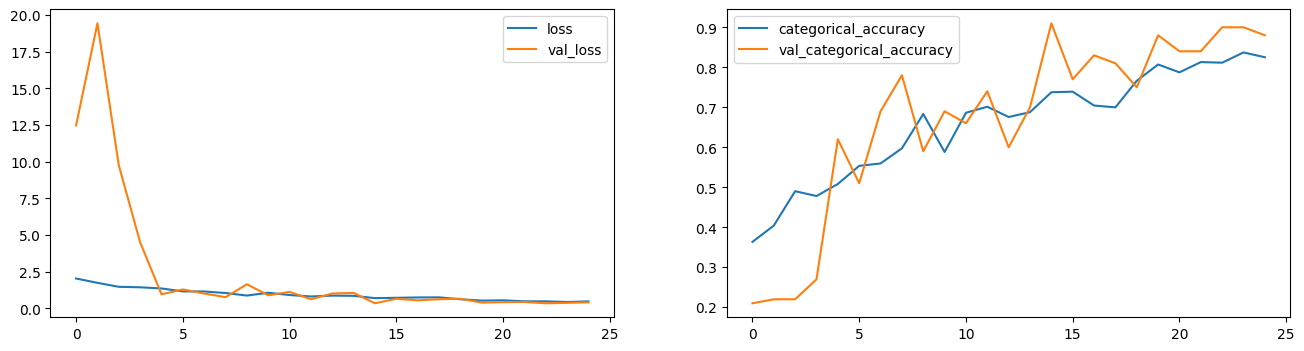

In [25]:
plot(curr_history)

The Model is good with training accuracy of 83% and validation accuracy of 91%.
Drop out is already high so , Now Lets Try the same Model with augmentation
# Model 2 : (Model 1 - Augmented)

In [36]:
curr_model_builder=ModelConv3D1()
curr_model_builder.init_paths(project_folder)
curr_model_builder.init_img_props(image_height=120,image_width=120)
curr_model_builder.init_hyperparams(frames_to_sample=20,batch_size=5,num_epochs=25)
curr_model=curr_model_builder.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
curr_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 20, 120, 120, 16   400       
                             )                                   
                                                                 
 activation_32 (Activation)  (None, 20, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_48 (Ba  (None, 20, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_32 (MaxPooli  (None, 10, 60, 60, 16)    0         
 ng3D)                                                           
                                                                 
 conv3d_33 (Conv3D)          (None, 10, 60, 60, 32)   

In [37]:
print("Total Params:", curr_model.count_params())
curr_history=curr_model_builder.train_model(curr_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 2.0100 - categorical_accuracy: 0.3492
Epoch 1: val_loss improved from inf to 4.94968, saving model to model_init_2023-09-2414_49_42.013819/model-00001-2.01003-0.34917-4.94968-0.24000.h5
133/133 [==============================] - 201s 1s/step - loss: 2.0100 - categorical_accuracy: 0.3492 - val_loss: 4.9497 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
133/133 [==============================] - ETA: 0s - loss: 1.6544 - categorical_accuracy: 0.4314
Epoch 2: val_loss improved from 4.94968 to 4.78432, saving model to model_init_2023-09-2414_49_42.013819/model-00002-1.65443-0.43137-4.78432-0.22000.h5
133/133 [==============================] - 196s 1s/step - loss: 1.6544 - categorical_accuracy: 0.4314 - val_loss: 4.7843 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
133/133 [==============================] - ETA: 0s - loss: 1.5388 - categorical_accuracy: 0.4480
Epoch 3: val_los

Max. Training Accuracy 0.8438913822174072
Max. Validaiton Accuracy 0.9100000262260437


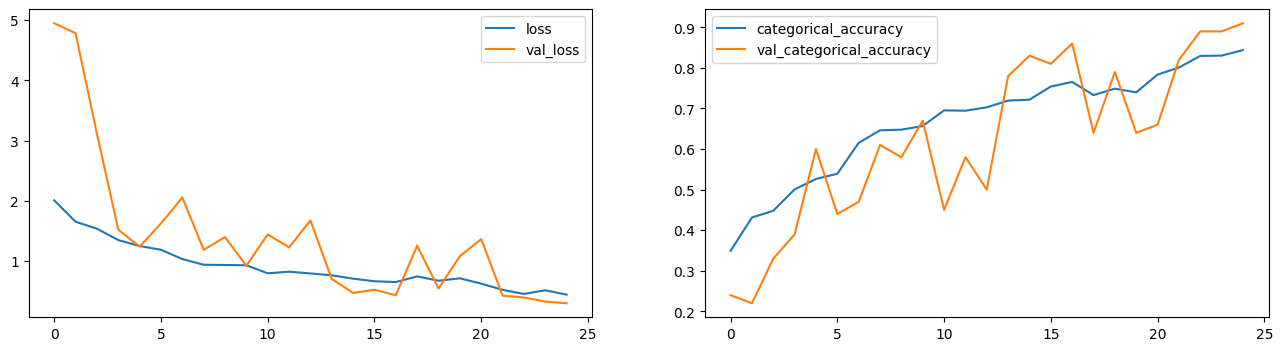

In [38]:
plot(curr_history)

The Model is good with training accuracy of 84% and validation accuracy of 91%. This model is very good for final selection

# Model 3:

In [39]:
class ModelConv3D3(ModelBuilder):

    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [40]:
curr_model_builder=ModelConv3D3()
curr_model_builder.init_paths(project_folder)
curr_model_builder.init_img_props(image_height=120,image_width=120)
curr_model_builder.init_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=30)
curr_model=curr_model_builder.define_model(dense_neurons=128,dropout=0.25)
curr_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_36 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_54 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_36 (MaxPooli  (None, 8, 60, 60, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_37 (Conv3D)          (None, 8, 60, 60, 32)    

In [41]:
print("Total Params:", curr_model.count_params())
curr_history=curr_model_builder.train_model(curr_model,augment_data=True)

Total Params: 909637
Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 1.6924 - categorical_accuracy: 0.3989
Epoch 1: val_loss improved from inf to 7.47039, saving model to model_init_2023-09-2416_08_32.612616/model-00001-1.69244-0.39894-7.47039-0.21000.h5
133/133 [==============================] - 160s 1s/step - loss: 1.6924 - categorical_accuracy: 0.3989 - val_loss: 7.4704 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 1.4250 - categorical_accuracy: 0.4736
Epoch 2: val_loss did not improve from 7.47039
133/133 [==============================] - 155s 1s/step - loss: 1.4250 - categorical_accuracy: 0.4736 - val_loss: 11.9266 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 1.3147 - categorical_accuracy: 0.4947
Epoch 3: val_loss improved from 7.47039 to 1.65213, saving model to model_init_2023-09-2416_08_32.612616/model-00003-1.31

Max. Training Accuracy 0.7428355813026428
Max. Validaiton Accuracy 0.7900000214576721


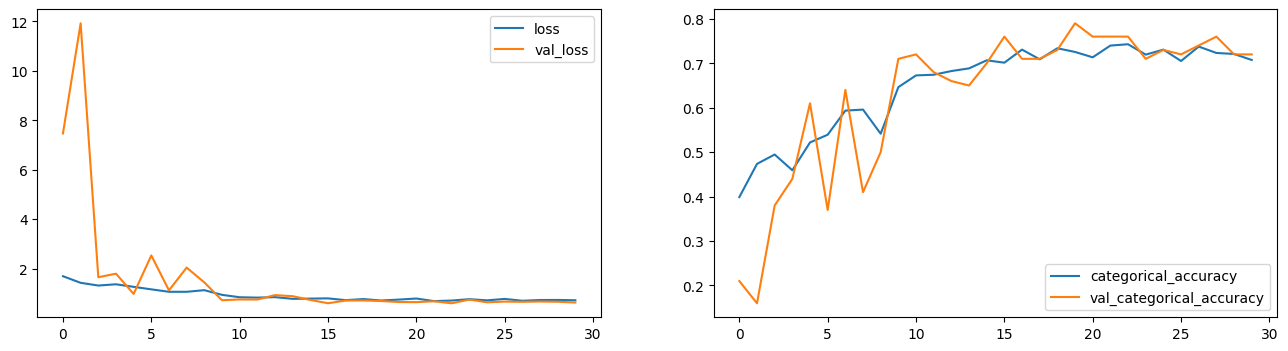

In [42]:
plot(curr_history)

Reducing parameters has taken a hit on the training and validation accuracy.

Lets Try Reducing the parameters even further
# Model : 4

In [43]:
class ModelConv3D4(ModelBuilder):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [44]:
curr_model_builder=ModelConv3D4()
curr_model_builder.init_paths(project_folder)
curr_model_builder.init_img_props(image_height=120,image_width=120)
curr_model_builder.init_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=30)
curr_model=curr_model_builder.define_model(dense_neurons=64,dropout=0.25)
curr_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_40 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_60 (Ba  (None, 16, 120, 120, 16   64        
 tchNormalization)           )                                   
                                                                 
 max_pooling3d_40 (MaxPooli  (None, 8, 60, 60, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_41 (Conv3D)          (None, 8, 60, 60, 32)   

In [45]:
print("Total Params:", curr_model.count_params())
curr_history=curr_model_builder.train_model(curr_model,augment_data=True)

Total Params: 504709
Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 1.7167 - categorical_accuracy: 0.3529
Epoch 1: val_loss improved from inf to 6.30150, saving model to model_init_2023-09-2417_31_05.091061/model-00001-1.71672-0.35294-6.30150-0.21000.h5
133/133 [==============================] - 160s 1s/step - loss: 1.7167 - categorical_accuracy: 0.3529 - val_loss: 6.3015 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 1.4327 - categorical_accuracy: 0.4442
Epoch 2: val_loss improved from 6.30150 to 1.56882, saving model to model_init_2023-09-2417_31_05.091061/model-00002-1.43270-0.44419-1.56882-0.37000.h5
133/133 [==============================] - 156s 1s/step - loss: 1.4327 - categorical_accuracy: 0.4442 - val_loss: 1.5688 - val_categorical_accuracy: 0.3700 - lr: 0.0010
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 1.2620 - categorical_accuracy: 0.4902
Epoch 3: val_loss

Max. Training Accuracy 0.8499245643615723
Max. Validaiton Accuracy 0.8399999737739563


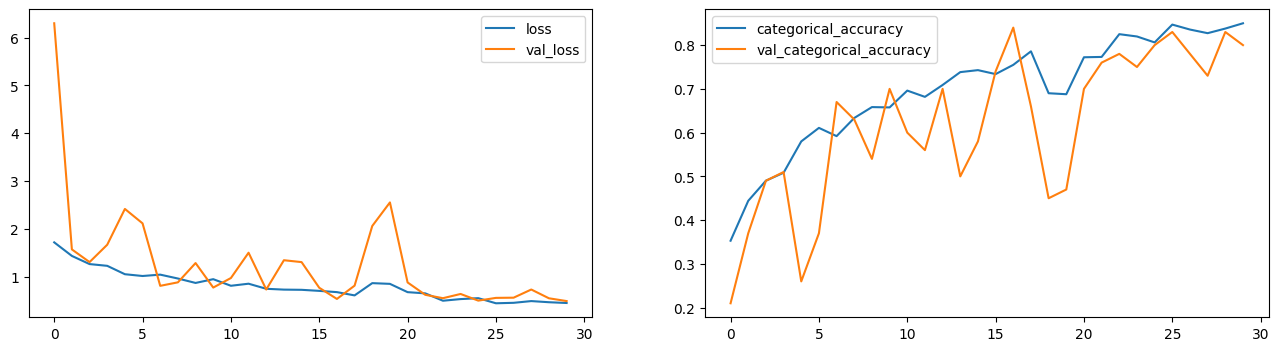

In [46]:
plot(curr_history)

The Model is good with training accuracy of 84% and validation accuracy of 83%.

# Model : 5
Cnn Lstm

In [49]:
class RnnCnn(ModelBuilder):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [54]:
curr_model_builder=RnnCnn()
curr_model_builder.init_paths(project_folder)
curr_model_builder.init_img_props(image_height=120,image_width=120)
curr_model_builder.init_hyperparams(frames_to_sample=20,batch_size=5,num_epochs=25)
curr_model=curr_model_builder.define_model(lstm_cells=128,dense_neurons=128,dropout=0.5)
curr_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_48 (TimeD  (None, 20, 120, 120, 16   448       
 istributed)                 )                                   
                                                                 
 time_distributed_49 (TimeD  (None, 20, 120, 120, 16   64        
 istributed)                 )                                   
                                                                 
 time_distributed_50 (TimeD  (None, 20, 60, 60, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_51 (TimeD  (None, 20, 60, 60, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_52 (TimeD  (None, 20, 60, 60, 32)  

In [55]:
print("Total Params:", curr_model.count_params())
curr_history=curr_model_builder.train_model(curr_model,augment_data=True)

Total Params: 1657445
Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 1.5736 - categorical_accuracy: 0.3069
Epoch 1: val_loss improved from inf to 1.94677, saving model to model_init_2023-09-2418_56_01.756630/model-00001-1.57361-0.30694-1.94677-0.25000.h5
133/133 [==============================] - 205s 2s/step - loss: 1.5736 - categorical_accuracy: 0.3069 - val_loss: 1.9468 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25
133/133 [==============================] - ETA: 0s - loss: 1.4967 - categorical_accuracy: 0.3401
Epoch 2: val_loss improved from 1.94677 to 1.90799, saving model to model_init_2023-09-2418_56_01.756630/model-00002-1.49670-0.34012-1.90799-0.20000.h5
133/133 [==============================] - 195s 1s/step - loss: 1.4967 - categorical_accuracy: 0.3401 - val_loss: 1.9080 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/25
133/133 [==============================] - ETA: 0s - loss: 1.3470 - categorical_accuracy: 0.4223
Epoch 3: val_los

Max. Training Accuracy 0.7745097875595093
Max. Validaiton Accuracy 0.7699999809265137


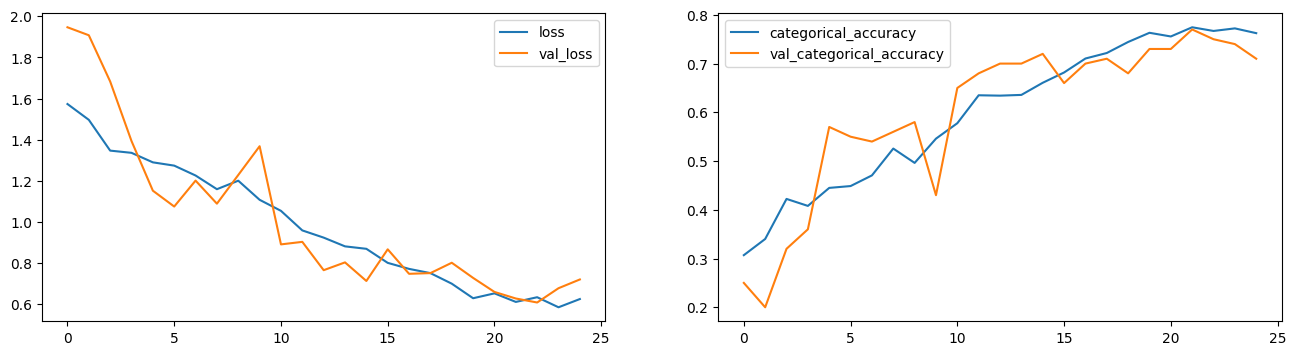

In [56]:
plot(curr_history)

# Model: 6 Transfer Learning

In [58]:
from tensorflow.keras.applications import mobilenet

In [59]:
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RnnCnn_Tl(ModelBuilder):

    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))


        for layer in model.layers:
            layer.trainable = False


        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17225924/17225924 [==============================] - 0s 0us/step


In [60]:
curr_model_builder=RnnCnn_Tl()
curr_model_builder.init_paths(project_folder)
curr_model_builder.init_img_props(image_height=120,image_width=120)
curr_model_builder.init_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
curr_model=curr_model_builder.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
curr_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeD  (None, 16, 3, 3, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_65 (TimeD  (None, 16, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_66 (TimeD  (None, 16, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_67 (TimeD  (None, 16, 1024)          0         
 istributed)                                                     
                                                                 
 lstm_4 (LSTM)               (None, 128)             

In [61]:
print("Total Params:", curr_model.count_params())
curr_history=curr_model_builder.train_model(curr_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.3459 - categorical_accuracy: 0.4201
Epoch 1: val_loss improved from inf to 0.89068, saving model to model_init_2023-09-2420_20_17.709520/model-00001-1.34592-0.42006-0.89068-0.65000.h5
133/133 [==============================] - 162s 1s/step - loss: 1.3459 - categorical_accuracy: 0.4201 - val_loss: 0.8907 - val_categorical_accuracy: 0.6500 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.8842 - categorical_accuracy: 0.6727
Epoch 2: val_loss improved from 0.89068 to 0.66220, saving model to model_init_2023-09-2420_20_17.709520/model-00002-0.88417-0.67270-0.66220-0.69000.h5
133/133 [==============================] - 157s 1s/step - loss: 0.8842 - categorical_accuracy: 0.6727 - val_loss: 0.6622 - val_categorical_accuracy: 0.6900 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.6730 - categorical_accuracy: 0.7406
Epoch 3: val_los

Max. Training Accuracy 0.9924585223197937
Max. Validaiton Accuracy 0.8399999737739563


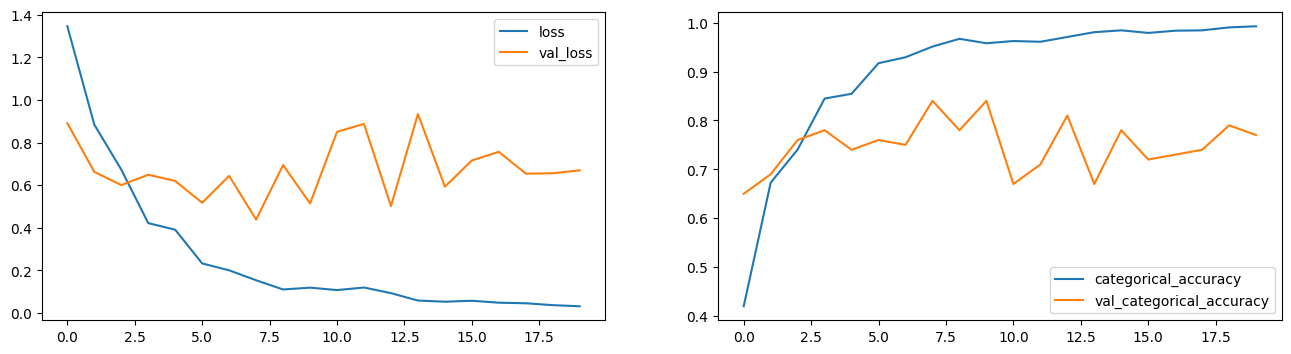

In [62]:
plot(curr_history)

Model is overfitting

# Model : 7
Transfer Learning with GRU and training all weights

In [76]:
from tensorflow.keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

class RnnCnn_Tl2(ModelBuilder):

    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))


        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes, activation='softmax'))


        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [77]:
curr_model_builder=RnnCnn_Tl2()
curr_model_builder.init_paths(project_folder)
curr_model_builder.init_img_props(image_height=160,image_width=160)
curr_model_builder.init_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
curr_model=curr_model_builder.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
curr_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_72 (TimeD  (None, 16, 5, 5, 1024)    3228864   
 istributed)                                                     
                                                                 
 time_distributed_73 (TimeD  (None, 16, 5, 5, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_74 (TimeD  (None, 16, 2, 2, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_75 (TimeD  (None, 16, 4096)          0         
 istributed)                                                     
                                                                 
 gru_1 (GRU)                 (None, 128)             

In [78]:
print("Total Params:", curr_model.count_params())
curr_history=curr_model_builder.train_model(curr_model,augment_data=True)

Total Params: 4872901
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 0.9715 - categorical_accuracy: 0.5950
Epoch 1: val_loss improved from inf to 0.73231, saving model to model_init_2023-09-2421_21_44.285442/model-00001-0.97153-0.59502-0.73231-0.63000.h5
133/133 [==============================] - 217s 2s/step - loss: 0.9715 - categorical_accuracy: 0.5950 - val_loss: 0.7323 - val_categorical_accuracy: 0.6300 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6026 - categorical_accuracy: 0.7443
Epoch 2: val_loss improved from 0.73231 to 0.58457, saving model to model_init_2023-09-2421_21_44.285442/model-00002-0.60257-0.74434-0.58457-0.74000.h5
133/133 [==============================] - 200s 2s/step - loss: 0.6026 - categorical_accuracy: 0.7443 - val_loss: 0.5846 - val_categorical_accuracy: 0.7400 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.6290 - categorical_accuracy: 0.7391
Epoch 3: val_los

Max. Training Accuracy 0.9886877536773682
Max. Validaiton Accuracy 0.9700000286102295


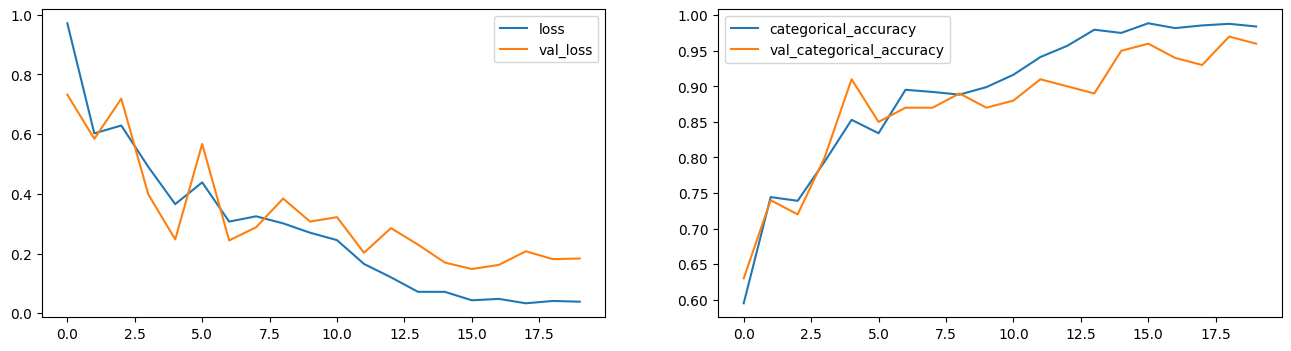

In [79]:
plot(curr_history)



The effects of training the weights is outstanding! 98% Training accuracy and 97% validation accuracy


# Model 8 :
Model 2 Optimized with less number of dropouts, params , filter size , sample frames and training for longer period with epoch 30

In [85]:
class ModelConv3D8(ModelBuilder):

    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = tf.keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [86]:
curr_model_builder=ModelConv3D8()
curr_model_builder.init_paths(project_folder)
curr_model_builder.init_img_props(image_height=120,image_width=120)
curr_model_builder.init_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=30)
curr_model=curr_model_builder.define_model(dense_neurons=128,dropout=0.25)
curr_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 16, 120, 120, 16   1312      
                             )                                   
                                                                 
 activation_56 (Activation)  (None, 16, 120, 120, 16   0         
                             )                                   
                                                                 
 batch_normalization_107 (B  (None, 16, 120, 120, 16   64        
 atchNormalization)          )                                   
                                                                 
 max_pooling3d_56 (MaxPooli  (None, 8, 60, 60, 16)     0         
 ng3D)                                                           
                                                                 
 conv3d_57 (Conv3D)          (None, 8, 60, 60, 32)   

In [87]:
print("Total Params:", curr_model.count_params())
curr_history=curr_model_builder.train_model(curr_model,augment_data=True)

Total Params: 909637
Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 1.6066 - categorical_accuracy: 0.4042
Epoch 1: val_loss improved from inf to 11.39475, saving model to model_init_2023-09-2423_09_53.535971/model-00001-1.60664-0.40422-11.39475-0.21000.h5
133/133 [==============================] - 160s 1s/step - loss: 1.6066 - categorical_accuracy: 0.4042 - val_loss: 11.3947 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 1.3120 - categorical_accuracy: 0.5121
Epoch 2: val_loss improved from 11.39475 to 8.28682, saving model to model_init_2023-09-2423_09_53.535971/model-00002-1.31196-0.51207-8.28682-0.19000.h5
133/133 [==============================] - 155s 1s/step - loss: 1.3120 - categorical_accuracy: 0.5121 - val_loss: 8.2868 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 1.1584 - categorical_accuracy: 0.5588
Epoch 3: val_

Max. Training Accuracy 0.8966817259788513
Max. Validaiton Accuracy 0.8600000143051147


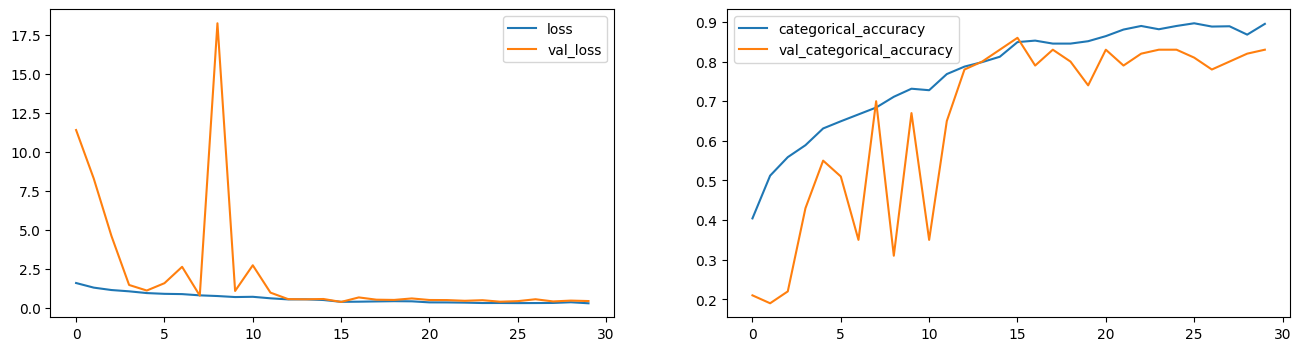

In [88]:
plot(curr_history)

After doing all the experiments, we finalized Model 8.

Reason:
Training accuracy - 89%
Validation accuracy - %
Number of parameters - 909637

The best weights of Model 8: model_init_2023-09-2423_09_53.535971/model-00016-0.40387-0.84917-0.39701-0.86000.h5 (10.5 MB). we considered this weight for model testing, Let's have look at the performance below

# Loading model and Testing

In [89]:
import time
from tensorflow.keras.models import load_model
model = load_model('model_init_2023-09-2423_09_53.535971/model-00016-0.40387-0.84917-0.39701-0.86000.h5')

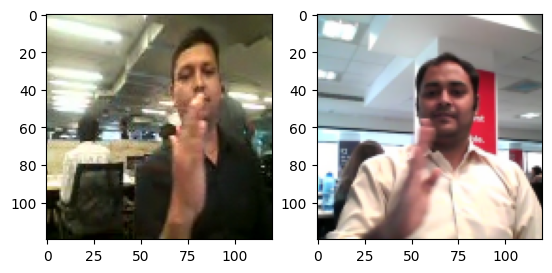

In [93]:
test_generator=RnnCnn()
test_generator.init_paths(project_folder)
test_generator.init_img_props(image_height=120,image_width=120)
test_generator.init_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])
axes[1].imshow(batch_data[3,15,:,:,:])

In [94]:
batch_labels

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [95]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 [==============================] - 0s 312ms/step
[0 3 1 1 2 3 3 3 3 0 0 2 0 3 3 4 3 4 2 0]
